In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from time import strftime
import os

In [2]:
# https://gitlab.com/dword4/nhlapi/-/blob/master/new-api.md?ref_type=heads
# const declare API URL
# https://api-web.nhle.com/v1/player/8471214/landing
# API_URL = 'https://statsapi.web.nhl.com/api/v1'
API_URL = 'https://api-web.nhle.com/v1'
all_plays = []

In [3]:
def get_matchup_games(start_date, end_date):
    r = requests.get(url=API_URL + '/schedule/' + str(start_date))
    data = r.json()

    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    matchup_games = {'next_start_date': '', 'game_ids': {'id': [], 'date': []}}

    matchup_games['next_start_date'] = data['nextStartDate']

    for day in data['gameWeek']:
        for game in day['games']:
            # game_date_timestamp = game['startTimeUTC']  # Read the game's start time
            # game_date = datetime.strptime(game_date_timestamp, '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d')
            game_date = day['date']
            # Strip the time and retain only the date this causes problems for the sweden games

            if datetime.strptime(game_date, '%Y-%m-%d').date() <= end_date_dt.date():
                matchup_games['game_ids']['id'].append(game['id'])
                matchup_games['game_ids']['date'].append(game_date)

    return matchup_games

In [4]:
def retrieve_schedule(start_date_str, end_date_str):
    all_game_ids = {'game_ids': [], 'game_dates': []}
    temp_week = get_matchup_games(start_date_str, end_date_str)

    all_game_ids['game_ids'].extend(temp_week['game_ids']['id'])
    all_game_ids['game_dates'].extend(temp_week['game_ids']['date'])

    end_date_dt = datetime.strptime(end_date_str, '%Y-%m-%d')

    while True:
        temp_next_start = datetime.strptime(temp_week['next_start_date'], '%Y-%m-%d')

        if temp_next_start <= end_date_dt:
            temp_start = temp_week['next_start_date']
            temp_week = get_matchup_games(temp_start, end_date_str)

            game_ids = temp_week['game_ids']['id']
            game_dates = temp_week['game_ids']['date']

            for game_id, game_date in zip(game_ids, game_dates):
                game_date_dt = datetime.strptime(game_date, '%Y-%m-%d').date()
                if game_date_dt <= end_date_dt.date():
                    all_game_ids['game_ids'].append(game_id)
                    all_game_ids['game_dates'].append(game_date)
                else:
                    # Instead of breaking here, move to the next week
                    break
        else:
            break

    return all_game_ids

In [5]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2024-05-10'

In [6]:
# Creating a dictionary to store the NHL team information
def get_team_info():
    nhl_teams = {}
    # https://api.nhle.com/stats/rest/en/team
    response = requests.get("https://api.nhle.com/stats/rest/en/team", params={"Content-Type": "application/json"})
    data = response.json()

    for team in data["data"]:
        team_id = team['id']
        team_info = {
            "fullName": team["fullName"],
            "triCode": team["triCode"]
        }
        nhl_teams[team_id] = team_info
    return nhl_teams

In [7]:
team_info = get_team_info()

In [8]:
start_2023 = '2023-10-10'
so_far = (retrieve_schedule(start_2023, yesterday))
# pd.DataFrame(so_far).iloc[-1]['game_dates']

In [9]:
def load_latest_psg_df(directory_path):
    # List all files in the specified directory
    files = os.listdir(directory_path)

    # Filter for files that match the 'psg' pattern with a date suffix
    psg_files = [f for f in files if f.startswith('psg_') and f.endswith('.csv')]

    # Extract the date from the filenames and convert to datetime objects
    dates = []
    for file in psg_files:
        # Extracting date part from the filename (assuming format 'psg_mmddyy.csv')
        date_str = file.split('_')[1].split('.')[0]
        # Parsing the date string to a datetime object
        date = datetime.strptime(date_str, '%m%d%y')
        dates.append((file, date))

    # Find the file with the latest date
    latest_file = max(dates, key=lambda x: x[1])[0]

    # Read the CSV file into a DataFrame
    psg_df = pd.read_csv(os.path.join(directory_path, latest_file))
    return psg_df

In [10]:
# https://api-web.nhle.com/v1/gamecenter/2022030415/play-by-play
def get_livedata_from_game(game_list):
  psg = {'id':[],'team':[],'shot':[],'shot_x':[],'shot_y':[],'goal':[], 'gid':[]}
  teams_dict = {'id':[], 'name':[], 'abbrev':[]}
  for game in game_list['game_ids']:
    # print(game)
    response = requests.get(API_URL + "/gamecenter/" + str(game) + "/play-by-play", params={"Content-Type": "application/json"})
    data = response.json()
    temp_game_plays = data['plays']
    all_plays.append(temp_game_plays)
    # todo record teams and team ids
    # temp_away_id = play['awayTeam']['id']
    # temp_home_id = play['awayTeam']['id']

    for play in temp_game_plays:
      if play['typeDescKey'] == 'shot-on-goal':
        #missed-shot
        # new api only has player ids
        psg['id'].append(play['details']['shootingPlayerId'])
        # psg['id'].append(temp_id)
        psg['team'].append(play['details']['eventOwnerTeamId']) # import the team abbr (triCode)
        psg['shot'].append(1)
        psg['goal'].append(0)
        psg['gid'].append(str(game)) #add the gameid, trim off year and type(post,etc...)
        psg['shot_x'].append(play['details']['xCoord'])
        psg['shot_y'].append(play['details']['yCoord'])
      elif play['typeDescKey'] == 'goal':
        psg['id'].append(play['details']['scoringPlayerId'])
        # psg['id'].append(temp_id)
        psg['team'].append(play['details']['eventOwnerTeamId'])
        psg['shot'].append(1)
        psg['goal'].append(1)
        psg['gid'].append(str(game))
        psg['shot_x'].append(play['details']['xCoord'])
        psg['shot_y'].append(play['details']['yCoord'])
  return psg

In [11]:
so_far

{'game_ids': [2023020001,
  2023020002,
  2023020003,
  2023020004,
  2023020005,
  2023020006,
  2023020007,
  2023020008,
  2023020009,
  2023020010,
  2023020011,
  2023020012,
  2023020013,
  2023020014,
  2023020015,
  2023020016,
  2023020017,
  2023020018,
  2023020019,
  2023020020,
  2023020021,
  2023020022,
  2023020023,
  2023020024,
  2023020025,
  2023020026,
  2023020027,
  2023020028,
  2023020029,
  2023020030,
  2023020031,
  2023020032,
  2023020033,
  2023020034,
  2023020035,
  2023020036,
  2023020037,
  2023020038,
  2023020039,
  2023020042,
  2023020041,
  2023020040,
  2023020043,
  2023020044,
  2023020045,
  2023020046,
  2023020047,
  2023020048,
  2023020049,
  2023020050,
  2023020051,
  2023020052,
  2023020053,
  2023020055,
  2023020054,
  2023020056,
  2023020057,
  2023020058,
  2023020059,
  2023020060,
  2023020061,
  2023020062,
  2023020063,
  2023020064,
  2023020065,
  2023020066,
  2023020067,
  2023020068,
  2023020069,
  2023020070,
  202302

In [12]:
# Usage
psg_df = load_latest_psg_df('/content/drive/MyDrive/nhl/')
# update_psg_df(psg_df, so_far)

In [13]:
psg_df

,id,team,shot,shot_x,shot_y,goal,gid,name,position,streak,dist,streak_lag
0,8478178,TBL,1,59,-26,0,2023020001,Darren Raddysh,D,1,39.70,NaN
1,8478010,TBL,1,81,8,0,2023020001,Brayden Point,C,1,11.31,NaN
2,8479661,TBL,1,55,30,0,2023020001,Tanner Jeannot,L,1,45.34,NaN
3,8479591,TBL,1,58,-30,0,2023020001,Michael Eyssimont,C,1,43.14,NaN
4,8478508,NSH,1,75,15,0,2023020001,Yakov Trenin,C,1,20.52,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
71465,8481624,VAN,1,69,-8,0,2023021196,Ilya Mikheyev,R,9,21.54,8.0
71466,8478434,VGK,1,69,-20,0,2023021196,Keegan Kolesar,R,6,28.28,5.0
71467,8477964,VGK,1,66,5,0,2023021196,Ivan Barbashev,C,3,23.54,2.0
71468,8478396,VGK,1,30,27,0,2023021196,Noah Hanifin,D,2,64.88,1.0


In [14]:
# old code to rescrape the entire season everytime
# psg = get_livedata_from_game(so_far)
# df = pd.DataFrame(psg)

In [15]:
def get_player_info(player_ids):
    players_info = []

    for player_id in player_ids:
        player_dict = {'name': '', 'position': '', 'id': player_id, 'team': ''}

        try:
            r = requests.get(f"{API_URL}/player/{player_id}/landing")
            if r.status_code == 200:
                data = r.json()
                player_dict['name'] = f"{data['firstName']['default']} {data['lastName']['default']}"
                player_dict['position'] = data['position']
                if data.get('currentTeamAbbrev'):
                    player_dict['team'] = data['currentTeamAbbrev']
                players_info.append(player_dict)
        except requests.RequestException as e:
            print(f"Request failed for player ID {player_id}: {e}")

    return players_info

In [16]:
# player_info = get_player_info(list(df['id'].unique()))
# players_dict = pd.read_csv('/content/drive/MyDrive/nhl/nhl_players_040324.csv')
# players_dict.to_csv('/content/drive/MyDrive/nhl/nhl_players_040324.csv')

In [17]:
# players_df = pd.DataFrame(players_dict)
# players_df

In [18]:
from datetime import datetime
import pandas as pd

def update_psg_df(psg_df, schedule, players_df, team_info):
    # Access the last 'gid' directly without sorting
    latest_gid = psg_df.iloc[-1]['gid']

    # Find the index of the latest_gid in the schedule
    try:
        latest_gid_index = schedule['game_ids'].index(latest_gid)
        latest_game_date_str = schedule['game_dates'][latest_gid_index]
        latest_game_date = datetime.strptime(latest_game_date_str, '%Y-%m-%d').date()
    except ValueError:
        # Handle the case where latest_gid is not in the schedule
        print(f"Error: 'gid' {latest_gid} not found in the schedule.")
        return psg_df

    # Initialize new_game_ids as a dictionary
    new_game_ids = {'game_ids': [], 'game_dates': []}

    # Filter out new games from the schedule
    for game_id, game_date in zip(schedule['game_ids'], schedule['game_dates']):
        game_date_dt = datetime.strptime(game_date, '%Y-%m-%d').date()
        if game_date_dt > latest_game_date:
            new_game_ids['game_ids'].append(game_id)
            new_game_ids['game_dates'].append(game_date)

    # Fetch and append data for new games
    new_game_df = None
    if new_game_ids['game_ids']:  # Check if there are new game IDs
        new_game_dict = get_livedata_from_game(new_game_ids)
        new_game_df = pd.DataFrame(new_game_dict)

        # Map team IDs to their tri-codes
        team_id_to_tricode = {team_id: team_data['triCode'] for team_id, team_data in team_info.items()}
        new_game_df['team'] = new_game_df['team'].map(team_id_to_tricode)

    # Merge with players_df and concatenate with psg_df
    if new_game_df is not None:
        new_game_df = pd.merge(new_game_df, players_df[['id', 'name', 'position']], on='id', how='left')
        psg_df = pd.concat([psg_df, new_game_df], ignore_index=True)

    return psg_df

# Example usage:
# psg_df = <your existing dataframe>
# schedule = <your schedule dictionary>
# players_df = <your players dataframe>
# team_info = <your team info dictionary>
# updated_psg_df = update_psg_df(psg_df, schedule, players_df, team_info)

In [19]:
# this takes about 4-5 minutes to run
# player_info = get_player_info(list(psg_df['id'].unique()))

In [20]:
# player_info = get_player_info(list(psg_df['id'].unique()))
player_info = pd.read_csv('/content/drive/MyDrive/nhl/nhl_players_040424.csv')
# players_df.to_csv('/content/drive/MyDrive/nhl/nhl_players_040424.csv', index=False)
players_df = pd.DataFrame(player_info)
# players_df

In [21]:
psg_df = update_psg_df(psg_df, so_far, players_df, team_info)
# psg_df

In [22]:
df = psg_df

In [23]:
# # Merging 'name' and 'position' columns from players_df to df based on 'id'
# df = pd.merge(df, players_df[['id', 'name', 'position']], on='id', how='left')

In [24]:
# # Map team IDs to tricodes using nhl_teams_dict
# team_id_to_tricode = {team_id: team_data['triCode'] for team_id, team_data in team_info.items()}
# df['team'] = df['team'].map(team_id_to_tricode)

In [25]:
def shots_since_last_goal(x):
    x['c'] = (x['goal'] != 0).cumsum()
    x['a'] = (x['c'] == 0).astype(int)
    x['b'] = x.groupby( 'c' ).cumcount()

    x['streak'] = x.groupby( 'c' ).cumcount() + x['a']

    return x
df = df.groupby('name', sort=False, group_keys=False).apply(shots_since_last_goal)
df.drop(['a', 'b', 'c'], inplace=True, axis=1)
df
# merged_df.groupby('name', sort=False, group_keys=False).apply(shots_since_last_goal)
# merged_df.drop(['a', 'b', 'c'], inplace=True, axis=1)
# merged_df

,id,team,shot,shot_x,shot_y,goal,gid,name,position,streak,dist,streak_lag
0,8478178,TBL,1,59,-26,0,2023020001,Darren Raddysh,D,1,39.70,NaN
1,8478010,TBL,1,81,8,0,2023020001,Brayden Point,C,1,11.31,NaN
2,8479661,TBL,1,55,30,0,2023020001,Tanner Jeannot,L,1,45.34,NaN
3,8479591,TBL,1,58,-30,0,2023020001,Michael Eyssimont,C,1,43.14,NaN
4,8478508,NSH,1,75,15,0,2023020001,Yakov Trenin,C,1,20.52,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
81482,8478856,VAN,1,48,-40,0,2023030242,Conor Garland,R,4,NaN,NaN
81483,8476967,EDM,1,-46,-38,0,2023030242,Brett Kulak,D,1,NaN,NaN
81484,8478856,VAN,1,81,25,0,2023030242,Conor Garland,R,5,NaN,NaN
81485,8477498,EDM,1,-30,-4,0,2023030242,Darnell Nurse,D,18,NaN,NaN


In [26]:
#define goal location coordinates to calculate distance for shot
GOAL_LOCATION = [89, 0]

# modify shot location coordinates
# if x coord is negative, reflect y coord so side which shot came from is consistent
df['shot_y'] = np.where(df['shot_x'] < 0, df['shot_y'] * -1, df['shot_y'])
df['shot_x'] = np.where(df['shot_x'] < 0, np.absolute(df['shot_x']), df['shot_x'])

def calculate_shot_distance(x,y):
  dist = math.dist([x,y], GOAL_LOCATION)
  return round(dist, 2)

In [27]:
# calculate shot distance
df['dist'] = df.apply(lambda x: calculate_shot_distance(x.shot_x, x.shot_y), axis=1)
df

,id,team,shot,shot_x,shot_y,goal,gid,name,position,streak,dist,streak_lag
0,8478178,TBL,1,59,-26,0,2023020001,Darren Raddysh,D,1,39.70,NaN
1,8478010,TBL,1,81,8,0,2023020001,Brayden Point,C,1,11.31,NaN
2,8479661,TBL,1,55,30,0,2023020001,Tanner Jeannot,L,1,45.34,NaN
3,8479591,TBL,1,58,-30,0,2023020001,Michael Eyssimont,C,1,43.14,NaN
4,8478508,NSH,1,75,15,0,2023020001,Yakov Trenin,C,1,20.52,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
81482,8478856,VAN,1,48,-40,0,2023030242,Conor Garland,R,4,57.28,NaN
81483,8476967,EDM,1,46,38,0,2023030242,Brett Kulak,D,1,57.38,NaN
81484,8478856,VAN,1,81,25,0,2023030242,Conor Garland,R,5,26.25,NaN
81485,8477498,EDM,1,30,4,0,2023030242,Darnell Nurse,D,18,59.14,NaN


In [28]:
# define a streak lag to see the streak number when a goal was scored
df['streak_lag'] = df.groupby('id', sort=False)['streak'].shift()
df

,id,team,shot,shot_x,shot_y,goal,gid,name,position,streak,dist,streak_lag
0,8478178,TBL,1,59,-26,0,2023020001,Darren Raddysh,D,1,39.70,NaN
1,8478010,TBL,1,81,8,0,2023020001,Brayden Point,C,1,11.31,NaN
2,8479661,TBL,1,55,30,0,2023020001,Tanner Jeannot,L,1,45.34,NaN
3,8479591,TBL,1,58,-30,0,2023020001,Michael Eyssimont,C,1,43.14,NaN
4,8478508,NSH,1,75,15,0,2023020001,Yakov Trenin,C,1,20.52,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
81482,8478856,VAN,1,48,-40,0,2023030242,Conor Garland,R,4,57.28,3.0
81483,8476967,EDM,1,46,38,0,2023030242,Brett Kulak,D,1,57.38,0.0
81484,8478856,VAN,1,81,25,0,2023030242,Conor Garland,R,5,26.25,4.0
81485,8477498,EDM,1,30,4,0,2023030242,Darnell Nurse,D,18,59.14,17.0


In [29]:
df.drop(['team', 'shot','streak_lag', 'name'], axis = 1)

,id,shot_x,shot_y,goal,gid,position,streak,dist
0,8478178,59,-26,0,2023020001,D,1,39.70
1,8478010,81,8,0,2023020001,C,1,11.31
2,8479661,55,30,0,2023020001,L,1,45.34
3,8479591,58,-30,0,2023020001,C,1,43.14
4,8478508,75,15,0,2023020001,C,1,20.52
...,...,...,...,...,...,...,...,...
81482,8478856,48,-40,0,2023030242,R,4,57.28
81483,8476967,46,38,0,2023030242,D,1,57.38
81484,8478856,81,25,0,2023030242,R,5,26.25
81485,8477498,30,4,0,2023030242,D,18,59.14


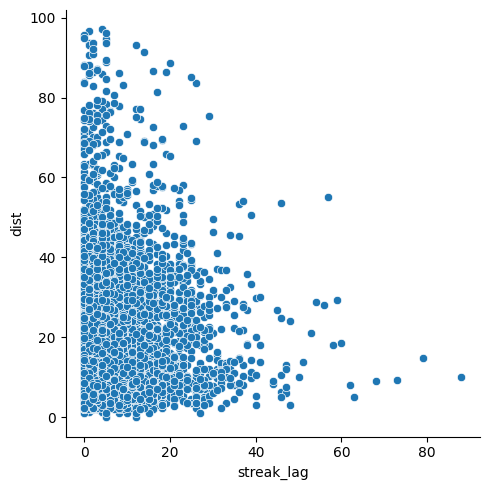

In [30]:
# plt.scatter(df['streak'], df['dist'], s=5)
# plt.show()

goals_df = df.loc[(df['goal'] == 1) & (df['position'] != 'D')]
# goals_df
# goals
# sns.relplot(data=goals_df, x='dist', y='streak', hue='goal', aspect=1.61)
# streak_lag distribution
# sns.histplot(data=goals_df, x='streak_lag', binwidth=1)
# plt.show()
# goals_df
sns.relplot(data=goals_df, x='streak_lag', y='dist')
plt.show()

In [31]:
streak_df = df.loc[df['position']!='D'].groupby('name', as_index=False).agg(streak=('streak','last'),dist_mean=('dist','mean')).sort_values(by='streak', ascending=False)
streak_df.head(50)

,name,streak,dist_mean
430,Taylor Raddysh,68,29.395417
413,Sean Couturier,46,28.223316
378,Reese Johnson,38,35.831569
341,Nino Niederreiter,36,25.806425
75,Calle Jarnkrok,34,26.550377
157,Ilya Mikheyev,32,26.854872
200,Joel Eriksson Ek,32,25.701148
52,Bo Groulx,32,30.144687
48,Beck Malenstyn,30,28.802745
76,Cam Atkinson,30,30.407841


In [32]:
#calculate number of goals by player, add id because there are 2 Ahos
# stats_df = df.groupby('name')['goal'].apply(lambda x: (x==1).sum()).reset_index(name='goal_count')
stats_df = df.groupby(['name','id','team'])['goal'].apply(lambda x: (x==1).sum()).reset_index(name='goal_count')
stats_df

,name,id,team,goal_count
0,A.J. Greer,8478421,CGY,6
1,Aaron Ekblad,8477932,FLA,4
2,Adam Boqvist,8480871,CBJ,1
3,Adam Erne,8477454,EDM,1
4,Adam Fantilli,8484166,CBJ,12
...,...,...,...,...
804,Zach Hyman,8475786,EDM,63
805,Zach Werenski,8478460,CBJ,11
806,Zach Whitecloud,8480727,VGK,2
807,Zack MacEwen,8479772,OTT,2


In [33]:
# count number of shots by player
# df.groupby('name')['shot'].count().reset_index(name='shot_count')
# df.groupby(['name','id'])['shot'].count().reset_index(name='shot_count')
stats_df = stats_df.merge(df.groupby(['name','id', 'team'])['shot'].count().reset_index(name='shot_count'), how='left', on=['name','id','team'])
stats_df

,name,id,team,goal_count,shot_count
0,A.J. Greer,8478421,CGY,6,57
1,Aaron Ekblad,8477932,FLA,4,112
2,Adam Boqvist,8480871,CBJ,1,45
3,Adam Erne,8477454,EDM,1,13
4,Adam Fantilli,8484166,CBJ,12,115
...,...,...,...,...,...
804,Zach Hyman,8475786,EDM,63,318
805,Zach Werenski,8478460,CBJ,11,202
806,Zach Whitecloud,8480727,VGK,2,55
807,Zack MacEwen,8479772,OTT,2,17


In [34]:
#calculate the number of games played
# stats_df = stats_df.merge(df.groupby('name')['gid'].nunique().reset_index(name='game_count'), how='left', on='name')
stats_df = stats_df.merge(df.groupby(['name','id'])['gid'].nunique().reset_index(name='game_count'), how='left', on=['name','id'])
stats_df

,name,id,team,goal_count,shot_count,game_count
0,A.J. Greer,8478421,CGY,6,57,35
1,Aaron Ekblad,8477932,FLA,4,112,50
2,Adam Boqvist,8480871,CBJ,1,45,29
3,Adam Erne,8477454,EDM,1,13,11
4,Adam Fantilli,8484166,CBJ,12,115,45
...,...,...,...,...,...,...
804,Zach Hyman,8475786,EDM,63,318,85
805,Zach Werenski,8478460,CBJ,11,202,66
806,Zach Whitecloud,8480727,VGK,2,55,40
807,Zack MacEwen,8479772,OTT,2,17,15


In [35]:
# df.groupby(['name','gid'])['shot'].count()
player_shot = stats_df.merge(df.groupby(['name', 'gid'])['shot'].count().reset_index(name='shots/game'), how='left', on='name')
player_shot

,name,id,team,goal_count,shot_count,game_count,gid,shots/game
0,A.J. Greer,8478421,CGY,6,57,35,2023020007,1
1,A.J. Greer,8478421,CGY,6,57,35,2023020025,3
2,A.J. Greer,8478421,CGY,6,57,35,2023020051,1
3,A.J. Greer,8478421,CGY,6,57,35,2023020063,1
4,A.J. Greer,8478421,CGY,6,57,35,2023020109,2
...,...,...,...,...,...,...,...,...
38665,Zemgus Girgensons,8476878,BUF,8,73,41,2023021148,3
38666,Zemgus Girgensons,8476878,BUF,8,73,41,2023021164,2
38667,Zemgus Girgensons,8476878,BUF,8,73,41,2023021170,1
38668,Zemgus Girgensons,8476878,BUF,8,73,41,2023021189,2


In [36]:
# player_shot.drop(player_shot.index, inplace=True)
player_shot

,name,id,team,goal_count,shot_count,game_count,gid,shots/game
0,A.J. Greer,8478421,CGY,6,57,35,2023020007,1
1,A.J. Greer,8478421,CGY,6,57,35,2023020025,3
2,A.J. Greer,8478421,CGY,6,57,35,2023020051,1
3,A.J. Greer,8478421,CGY,6,57,35,2023020063,1
4,A.J. Greer,8478421,CGY,6,57,35,2023020109,2
...,...,...,...,...,...,...,...,...
38665,Zemgus Girgensons,8476878,BUF,8,73,41,2023021148,3
38666,Zemgus Girgensons,8476878,BUF,8,73,41,2023021164,2
38667,Zemgus Girgensons,8476878,BUF,8,73,41,2023021170,1
38668,Zemgus Girgensons,8476878,BUF,8,73,41,2023021189,2


In [37]:
player_shot.head(20)
to_drop = player_shot[['goal_count','shot_count', 'game_count']]
player_shot.drop(to_drop, axis=1, inplace=True)
player_shot

,name,id,team,gid,shots/game
0,A.J. Greer,8478421,CGY,2023020007,1
1,A.J. Greer,8478421,CGY,2023020025,3
2,A.J. Greer,8478421,CGY,2023020051,1
3,A.J. Greer,8478421,CGY,2023020063,1
4,A.J. Greer,8478421,CGY,2023020109,2
...,...,...,...,...,...
38665,Zemgus Girgensons,8476878,BUF,2023021148,3
38666,Zemgus Girgensons,8476878,BUF,2023021164,2
38667,Zemgus Girgensons,8476878,BUF,2023021170,1
38668,Zemgus Girgensons,8476878,BUF,2023021189,2


In [38]:
stats_df.to_csv('stats_df.csv')

In [39]:
player_shot.to_csv('player_shot.csv')

In [40]:
# stats_df = stats_df.merge(player_shot.groupby('name').var().reset_index(name='shot_var') how='left', on='name')
# stats_df['shot_var'] = stats_df.merge(player_shot.groupby('name').var(), how='left', on='name')
# player_shot.groupby(['name','id']).std().reset_index()
# stats_df = stats_df.merge(player_shot.groupby(['name','id']).std().reset_index(), how='left', on=['name','id'])

# Group by 'name' and 'id', then calculate the standard deviation for 'shots/game'
player_shot_std = player_shot.groupby(['name', 'id'])['shots/game'].std().reset_index()

# Merge this data back into the 'stats_df' DataFrame
stats_df = stats_df.merge(player_shot_std, how='left', on=['name', 'id'])

stats_df = stats_df.rename(columns={'shots/game': 'shot_dev'})
stats_df

,name,id,team,goal_count,shot_count,game_count,shot_dev
0,A.J. Greer,8478421,CGY,6,57,35,1.190297
1,Aaron Ekblad,8477932,FLA,4,112,50,1.393278
2,Adam Boqvist,8480871,CBJ,1,45,29,0.827484
3,Adam Erne,8477454,EDM,1,13,11,0.404520
4,Adam Fantilli,8484166,CBJ,12,115,45,1.672716
...,...,...,...,...,...,...,...
804,Zach Hyman,8475786,EDM,63,318,85,1.820210
805,Zach Werenski,8478460,CBJ,11,202,66,1.699582
806,Zach Whitecloud,8480727,VGK,2,55,40,0.667467
807,Zack MacEwen,8479772,OTT,2,17,15,0.516398


In [41]:
# calculate shooting percentage across the time period
stats_df['shot_pct'] = (stats_df['goal_count'] / stats_df['shot_count'])*100
stats_df

,name,id,team,goal_count,shot_count,game_count,shot_dev,shot_pct
0,A.J. Greer,8478421,CGY,6,57,35,1.190297,10.526316
1,Aaron Ekblad,8477932,FLA,4,112,50,1.393278,3.571429
2,Adam Boqvist,8480871,CBJ,1,45,29,0.827484,2.222222
3,Adam Erne,8477454,EDM,1,13,11,0.404520,7.692308
4,Adam Fantilli,8484166,CBJ,12,115,45,1.672716,10.434783
...,...,...,...,...,...,...,...,...
804,Zach Hyman,8475786,EDM,63,318,85,1.820210,19.811321
805,Zach Werenski,8478460,CBJ,11,202,66,1.699582,5.445545
806,Zach Whitecloud,8480727,VGK,2,55,40,0.667467,3.636364
807,Zack MacEwen,8479772,OTT,2,17,15,0.516398,11.764706


In [42]:
#calculate shots/game across time period
stats_df['shots/g'] = stats_df['shot_count'] / stats_df['game_count']
stats_df

,name,id,team,goal_count,shot_count,game_count,shot_dev,shot_pct,shots/g
0,A.J. Greer,8478421,CGY,6,57,35,1.190297,10.526316,1.628571
1,Aaron Ekblad,8477932,FLA,4,112,50,1.393278,3.571429,2.240000
2,Adam Boqvist,8480871,CBJ,1,45,29,0.827484,2.222222,1.551724
3,Adam Erne,8477454,EDM,1,13,11,0.404520,7.692308,1.181818
4,Adam Fantilli,8484166,CBJ,12,115,45,1.672716,10.434783,2.555556
...,...,...,...,...,...,...,...,...,...
804,Zach Hyman,8475786,EDM,63,318,85,1.820210,19.811321,3.741176
805,Zach Werenski,8478460,CBJ,11,202,66,1.699582,5.445545,3.060606
806,Zach Whitecloud,8480727,VGK,2,55,40,0.667467,3.636364,1.375000
807,Zack MacEwen,8479772,OTT,2,17,15,0.516398,11.764706,1.133333


In [43]:
# replace infinite shooting pcts with zero
stats_df.replace([np.inf, -np.inf], 0, inplace=True)
stats_df = stats_df.sort_values(['shot_count','shot_pct'], ascending=[False, True]).round(2)
# stats_df

In [44]:
#  reorder the columns you jabroni
stats_df = stats_df[['name','id','team', 'goal_count', 'shot_count', 'shot_pct', 'shots/g', 'game_count']]
stats_df.head(50)

,name,id,team,goal_count,shot_count,shot_pct,shots/g,game_count
537,Nathan MacKinnon,8477492,COL,54,439,12.30,4.93,89
191,David Pastrnak,8477956,BOS,52,418,12.44,4.49,93
70,Auston Matthews,8479318,TOR,72,396,18.18,4.50,88
245,Filip Forsberg,8476887,NSH,51,365,13.97,4.10,89
92,Brady Tkachuk,8480801,OTT,38,359,10.58,4.49,80
792,William Nylander,8477939,TOR,43,338,12.72,3.84,88
65,Artemi Panarin,8478550,NYR,57,331,17.22,3.89,85
151,Cole Caufield,8481540,MTL,33,323,10.22,4.09,79
804,Zach Hyman,8475786,EDM,63,318,19.81,3.74,85
565,Nikita Kucherov,8476453,TBL,44,317,13.88,3.82,83


In [45]:
merged_df =stats_df.merge(streak_df, on='name').sort_values('shot_count', ascending=False).head(50)
merged_df

,name,id,team,goal_count,shot_count,shot_pct,shots/g,game_count,streak,dist_mean
0,Nathan MacKinnon,8477492,COL,54,439,12.30,4.93,89,5,31.365371
1,David Pastrnak,8477956,BOS,52,418,12.44,4.49,93,7,30.031628
2,Auston Matthews,8479318,TOR,72,396,18.18,4.50,88,7,25.251775
3,Filip Forsberg,8476887,NSH,51,365,13.97,4.10,89,5,30.833780
4,Brady Tkachuk,8480801,OTT,38,359,10.58,4.49,80,7,26.946639
5,William Nylander,8477939,TOR,43,338,12.72,3.84,88,1,30.744913
6,Artemi Panarin,8478550,NYR,57,331,17.22,3.89,85,0,33.861148
7,Cole Caufield,8481540,MTL,33,323,10.22,4.09,79,4,27.543251
8,Zach Hyman,8475786,EDM,63,318,19.81,3.74,85,4,17.049057
9,Nikita Kucherov,8476453,TBL,44,317,13.88,3.82,83,11,33.210938


In [46]:
stats_df.merge(streak_df, on='name').sort_values('streak', ascending=False).head(50)

,name,id,team,goal_count,shot_count,shot_pct,shots/g,game_count,streak,dist_mean
216,Taylor Raddysh,8479390,CHI,5,120,4.17,2.07,58,68,29.395417
81,Sean Couturier,8476461,PHI,14,196,7.14,2.76,71,46,28.223316
405,Reese Johnson,8481147,CHI,2,51,3.92,1.76,29,38,35.831569
106,Nino Niederreiter,8475799,WPG,18,179,10.06,2.67,67,36,25.806425
260,Calle Jarnkrok,8475714,TOR,10,106,9.43,2.12,50,34,26.550377
28,Joel Eriksson Ek,8478493,MIN,30,270,11.11,3.55,76,32,25.701148
147,Ilya Mikheyev,8481624,VAN,11,156,7.05,2.14,73,32,26.854872
443,Bo Groulx,8480870,ANA,0,32,0.00,1.52,21,32,30.144687
361,Kent Johnson,8482660,CBJ,6,63,9.52,2.03,31,30,31.406032
268,Beck Malenstyn,8479359,WSH,6,102,5.88,1.82,56,30,28.802745


In [47]:
df[df['name'] == 'David Pastrnak']

,id,team,shot,shot_x,shot_y,goal,gid,name,position,streak,dist,streak_lag
373,8477956,BOS,1,67,18,1,2023020006,David Pastrnak,R,0,28.43,NaN
387,8477956,BOS,1,87,9,0,2023020006,David Pastrnak,R,1,9.22,0.0
394,8477956,BOS,1,89,10,0,2023020006,David Pastrnak,R,2,10.00,1.0
397,8477956,BOS,1,77,-9,1,2023020006,David Pastrnak,R,0,15.00,2.0
1272,8477956,BOS,1,60,18,0,2023020021,David Pastrnak,R,1,34.13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80966,8477956,BOS,1,51,11,0,2023030211,David Pastrnak,R,3,39.56,2.0
80970,8477956,BOS,1,80,7,0,2023030211,David Pastrnak,R,4,11.40,3.0
81397,8477956,BOS,1,76,33,0,2023030213,David Pastrnak,R,5,35.47,4.0
81410,8477956,BOS,1,46,10,0,2023030213,David Pastrnak,R,6,44.15,5.0


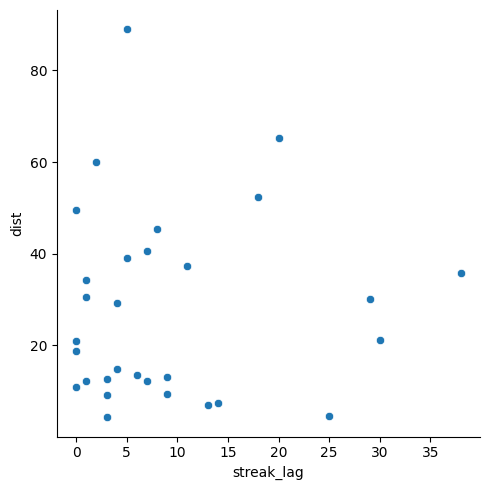

In [48]:
# Assuming player_dict is a DataFrame with columns 'name', 'position', 'id', 'team'
# Find Nazem Kadri's player ID
matthew_tkachuk_id = player_info.loc[player_info['name'] == 'Matthew Tkachuk', 'id'].iloc[0]

# Filter the DataFrame for goals scored by Nazem Kadri and not by a defender
goals_df = df.loc[(df['goal'] == 1) & (df['position'] != 'D') & (df['id'] == matthew_tkachuk_id)]

# Visualize the relationship between 'streak_lag' and 'dist' for Nazem Kadri
sns.relplot(data=goals_df, x='streak_lag', y='dist')
plt.show()



In [49]:
def player_shot_dist_vs_streak(player_name):
  player_name_id = player_info.loc[player_info['name'] == player_name, 'id'].iloc[0]
  # Filter the DataFrame for goals scored by player and not by a defender
  goals_df = df.loc[(df['goal'] == 1) & (df['id'] == player_name_id)]

  # Visualize the relationship between 'streak_lag' and 'dist' for Nazem Kadri
  sns.relplot(data=goals_df, x='streak_lag', y='dist')
  plt.show()


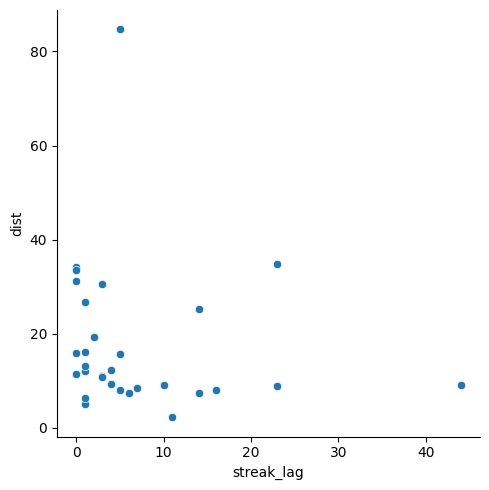

In [50]:
player_shot_dist_vs_streak('Joel Eriksson Ek')

In [51]:
goals_df = df.loc[(df['goal'] == 1) & (df['position'] != 'D')]

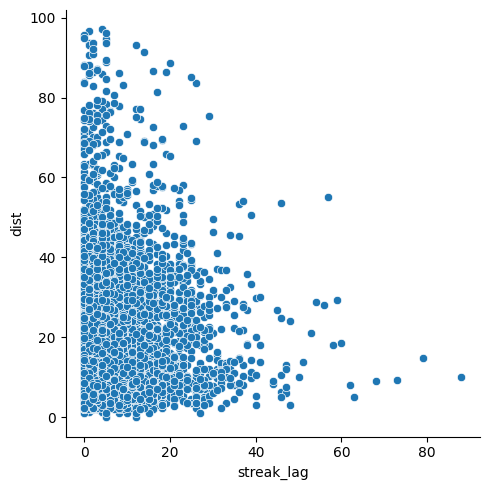

In [52]:
  # player_name_id = players_dict.loc[players_dict['name'] == player_name, 'id'].iloc[0]
  # Filter the DataFrame for goals scored by player and not by a defender
  # goals_df = df.loc[(df['goal'] == 1) & (df['id'] == player_name_id)]

  # Visualize the relationship between 'streak_lag' and 'dist' for Nazem Kadri
  sns.relplot(data=goals_df, x='streak_lag', y='dist')
  plt.show()